In [1]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks
import os

In [18]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32*2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32*2, 64*2, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64*2, 128*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128*2, 128*2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128*2, 256*2, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256*2 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [19]:
trainloader, testloader = load_cifar10()

In [20]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 6,341,002


In [21]:
# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            out = model(inputs)

            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 != 0:
                running_loss += loss.item()
                _, predicted = out.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [22]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=40)


Starting training...
Training on mps
Epoch: 1/40, Batch: 99, Loss: 1.7994, Acc: 25.21%
Epoch: 1/40, Batch: 199, Loss: 1.6225, Acc: 30.00%
Epoch: 1/40, Batch: 299, Loss: 1.5216, Acc: 33.93%
Epoch 1 completed: Loss: 1.5313, Accuracy: 37.05%
Epoch: 2/40, Batch: 99, Loss: 1.2270, Acc: 52.63%
Epoch: 2/40, Batch: 199, Loss: 0.9898, Acc: 54.42%
Epoch: 2/40, Batch: 299, Loss: 0.9903, Acc: 56.17%
Epoch 2 completed: Loss: 1.0601, Accuracy: 57.47%
Epoch: 3/40, Batch: 99, Loss: 1.0756, Acc: 64.26%
Epoch: 3/40, Batch: 199, Loss: 0.9640, Acc: 64.95%
Epoch: 3/40, Batch: 299, Loss: 0.9553, Acc: 65.93%
Epoch 3 completed: Loss: 0.8471, Accuracy: 66.54%
Epoch: 4/40, Batch: 99, Loss: 0.7198, Acc: 70.72%
Epoch: 4/40, Batch: 199, Loss: 0.7320, Acc: 71.64%
Epoch: 4/40, Batch: 299, Loss: 0.6360, Acc: 71.99%
Epoch 4 completed: Loss: 0.7063, Accuracy: 72.31%
Epoch: 5/40, Batch: 99, Loss: 0.8283, Acc: 75.21%
Epoch: 5/40, Batch: 199, Loss: 0.6913, Acc: 75.86%
Epoch: 5/40, Batch: 299, Loss: 0.5328, Acc: 76.22%
Ep

In [23]:
filepath='weak_model.pth'

os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
torch.save(model.state_dict(), filepath)

print(f"Model saved to {filepath}")

Model saved to weak_model.pth


# Time for some wiggles

In [155]:
def wiggly_relu(x):
    return nn.functional.relu(x) + 0.1*torch.sin(100 * x)

In [156]:
x = torch.arange(-3, 3.01, 0.01)

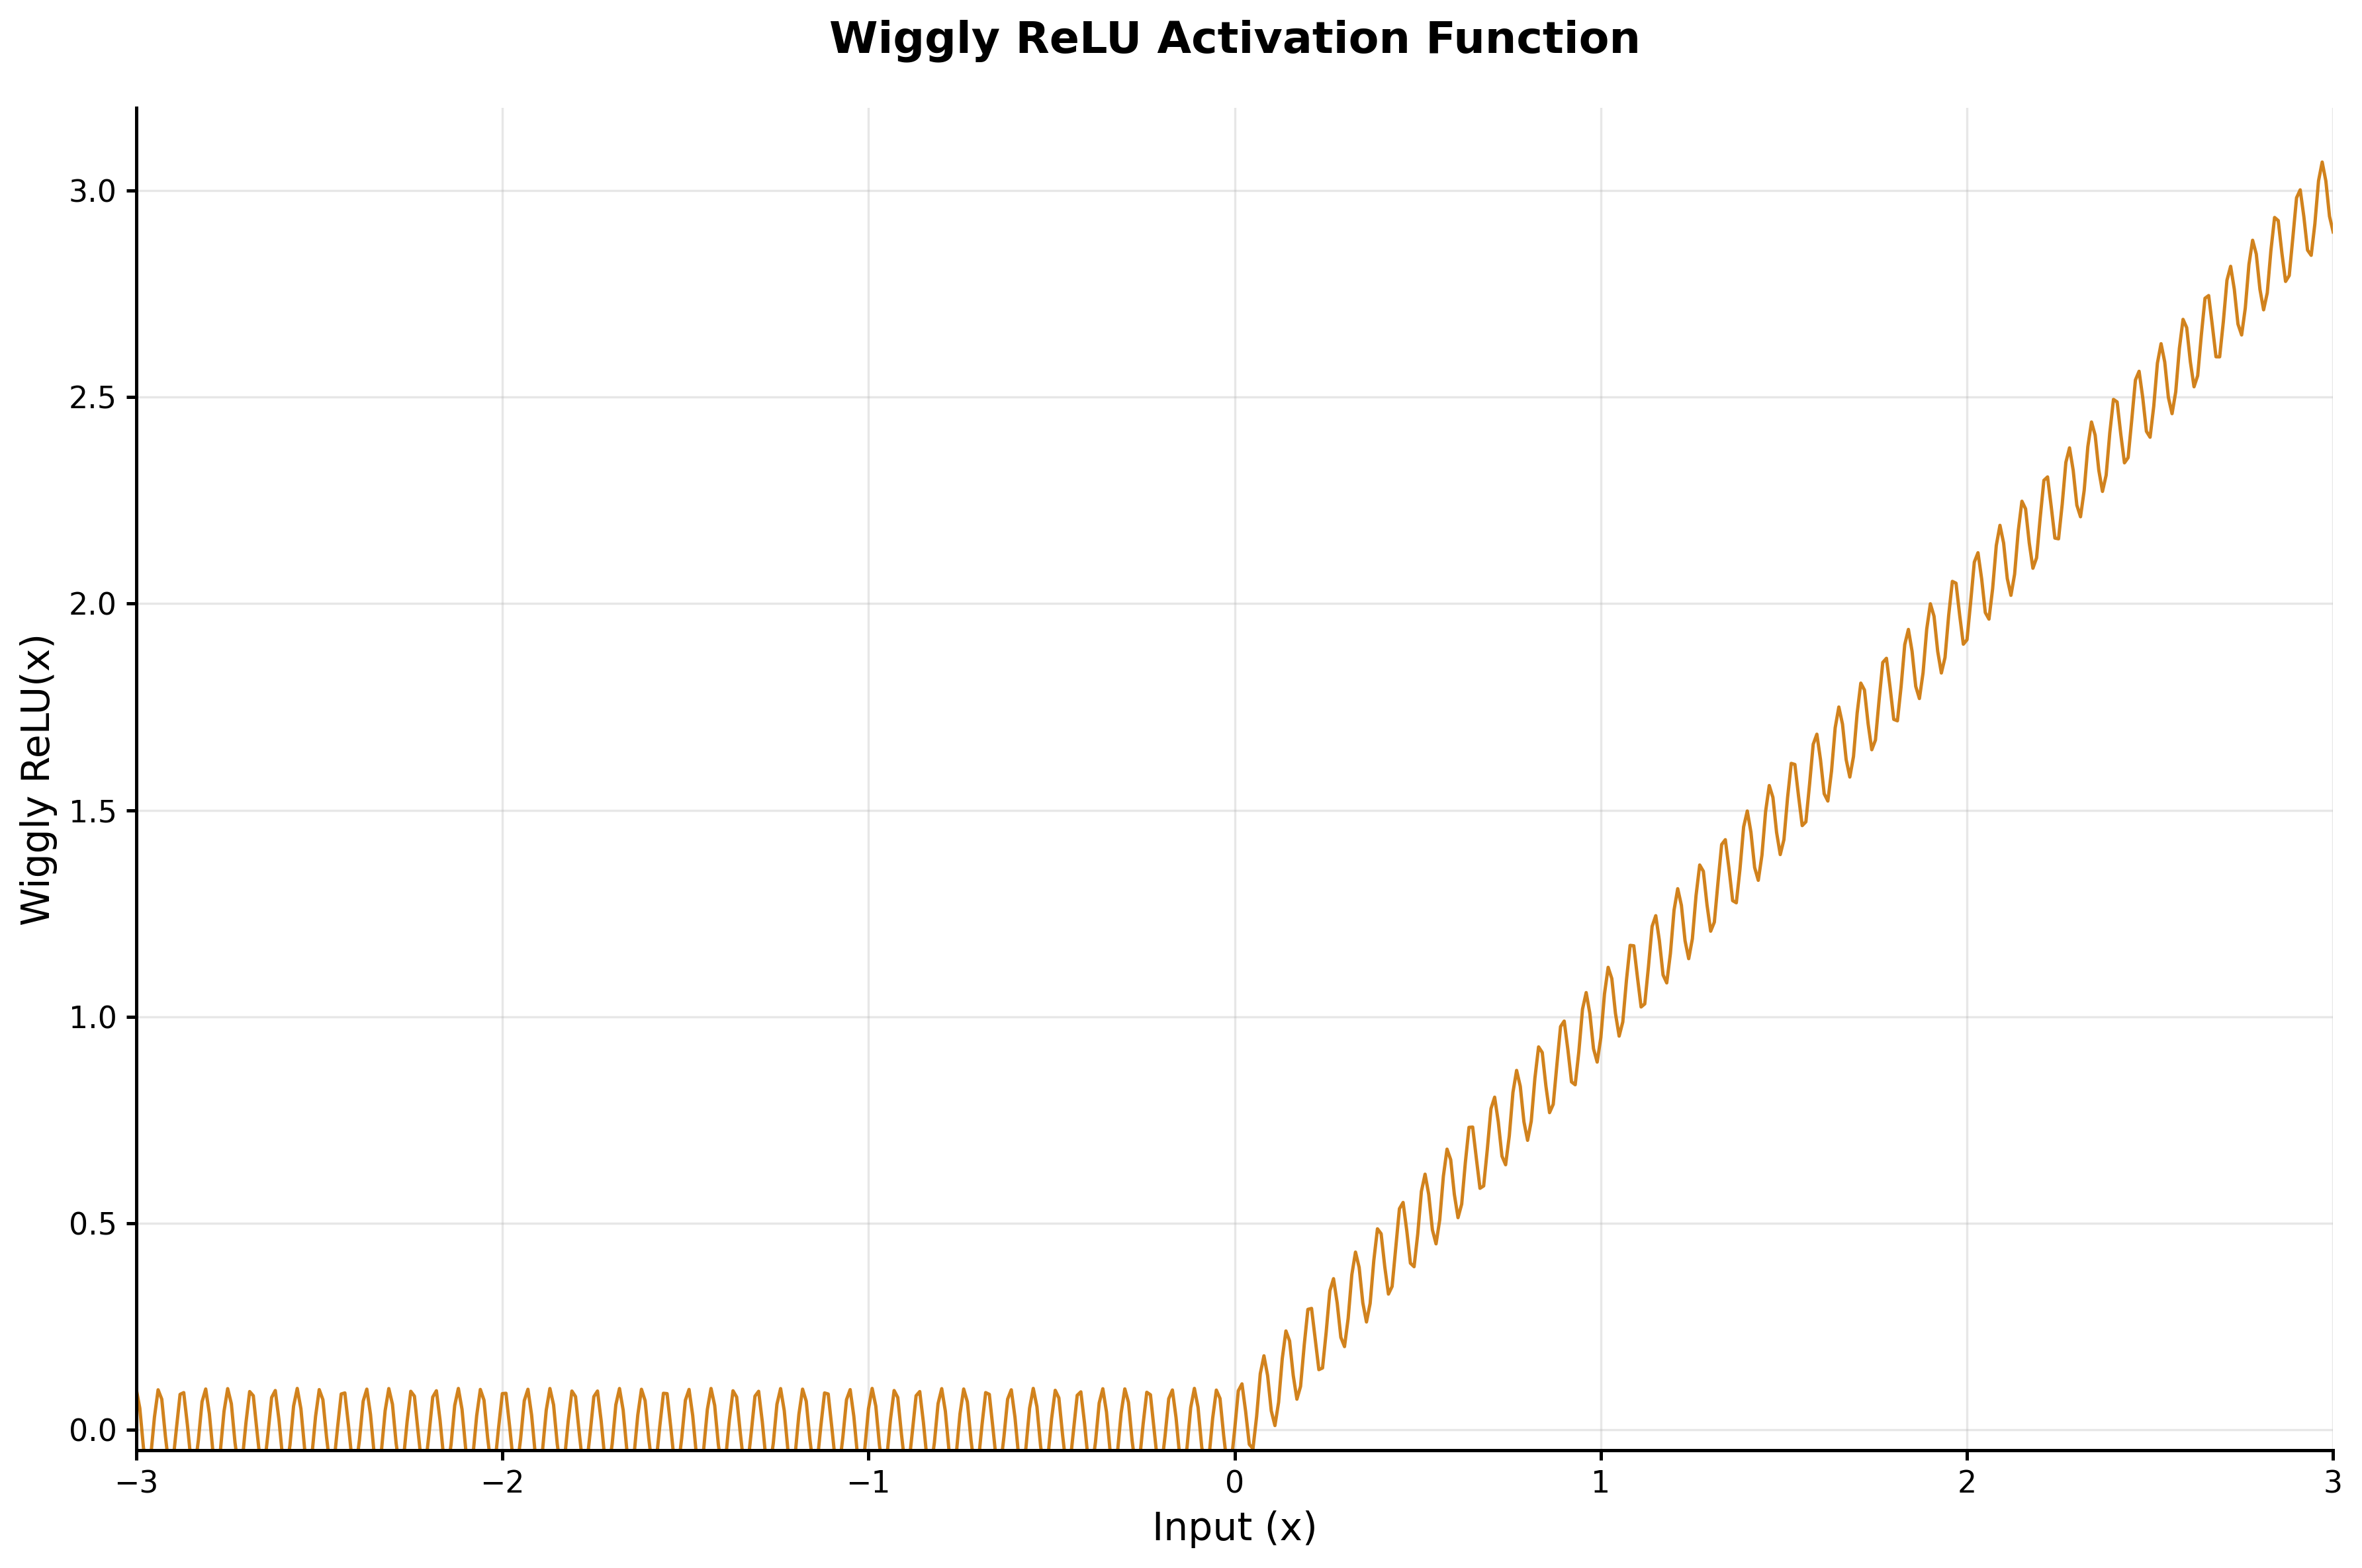

In [157]:
y= wiggly_relu(x)
plt.figure(figsize=(12, 8), dpi=300)  # High resolution with larger size

# Create the plot with thinner line
plt.plot(x.numpy(), y.numpy(), linewidth=1.2, color='#cc7504', alpha=0.9)

# Professional styling
plt.xlabel('Input (x)', fontsize=14, fontweight='medium')
plt.ylabel('Wiggly ReLU(x)', fontsize=14, fontweight='medium')
plt.title('Wiggly ReLU Activation Function', fontsize=16, fontweight='bold', pad=20)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=11, width=1.2)
plt.tick_params(axis='both', which='minor', labelsize=9, width=0.8)

# Add grid for better readability
plt.grid(True, alpha=0.3, linewidth=0.8)

# Set axis limits for better framing
plt.xlim(-3, 3)
plt.ylim(-0.05, 3.2)

# Add subtle styling touches
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [198]:
def wiggly_relu(x):
    return nn.functional.relu(x) + 0.02*torch.sin(200 * x)

class WiggleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(WiggleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32*2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32*2, 64*2, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64*2, 128*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128*2, 128*2, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128*2, 256*2, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256*2 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = wiggly_relu(self.conv3(x))
        x = wiggly_relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = wiggly_relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        
        # x = self.relu(self.fc1(x))
        x = wiggly_relu(self.fc1(x))
        x = self.fc2(x)
    
        return x

In [199]:
wiggle_model = WiggleCNN(num_classes=10)  # Make sure num_classes matches what you used when saving

# Load the saved state dictionary
filepath = 'weak_model.pth'
wiggle_model.load_state_dict(torch.load(filepath))
wiggle_model = wiggle_model.to('mps')

# Set the model to evaluation mode (important for inference)
wiggle_model.eval()

print(f"Model loaded from {filepath}")

Model loaded from weak_model.pth


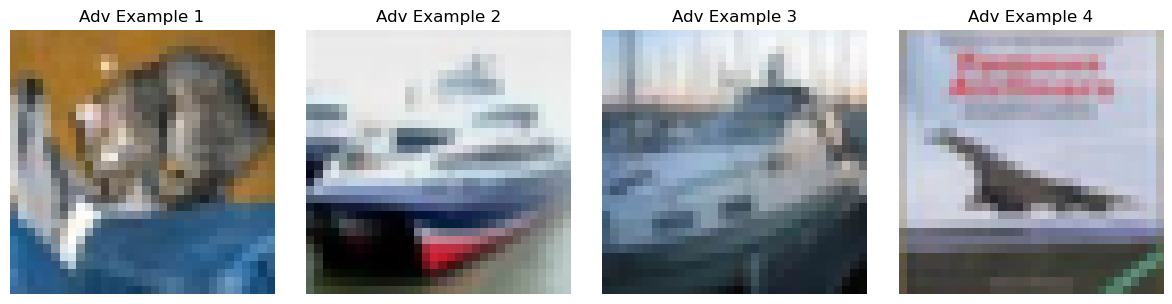

tensor([3, 8, 0, 0, 6], device='mps:0')
Attack success rate: 40.00%
5


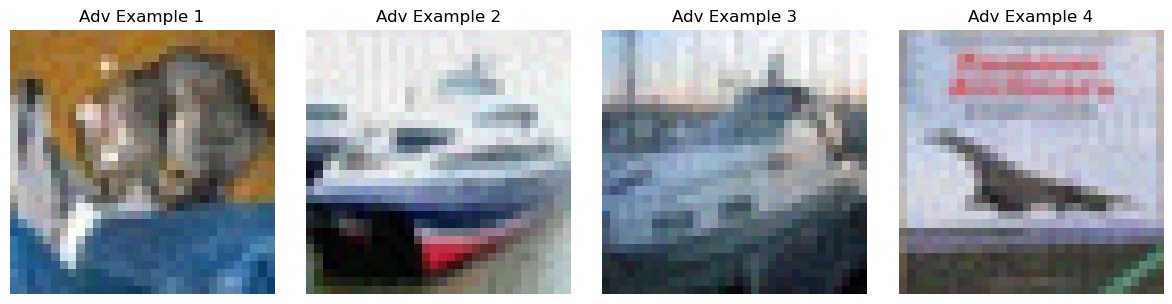

In [188]:
# Simple setup - no complex preprocessing nonsense
wiggle_model = wiggle_model.to('mps')
wiggle_model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(wiggle_model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(wiggle_model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(wiggle_model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(wiggle_model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[0:5], labels.to(device)[0:5]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = wiggle_model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [178]:
evaluate_model(wiggle_model, testloader)


Overall Test Accuracy: 79.11%

Per-class accuracies:
plane: 77.40%
car: 91.70%
bird: 64.40%
cat: 85.00%
deer: 85.60%
dog: 66.00%
frog: 67.50%
horse: 80.00%
ship: 83.20%
truck: 90.30%


79.11

In [50]:
evaluate_model(model, testloader)


Overall Test Accuracy: 85.81%

Per-class accuracies:
plane: 81.00%
car: 94.90%
bird: 77.80%
cat: 77.20%
deer: 89.20%
dog: 81.00%
frog: 90.40%
horse: 85.90%
ship: 91.90%
truck: 88.80%


85.81

In [ ]:
from autoattack import AutoAttack

adversary = AutoAttack(wiggle_model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

128
using custom version including apgd-ce, apgd-dlr.
initial accuracy: 89.06%


In [ ]:
adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'], device='mps')
adversary.apgd.n_restarts = 1
for images, labels in testloader:
    print(len(images))
    x_adv = adversary.run_standard_evaluation(images, labels)
    # print(x_adv)

In [14]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

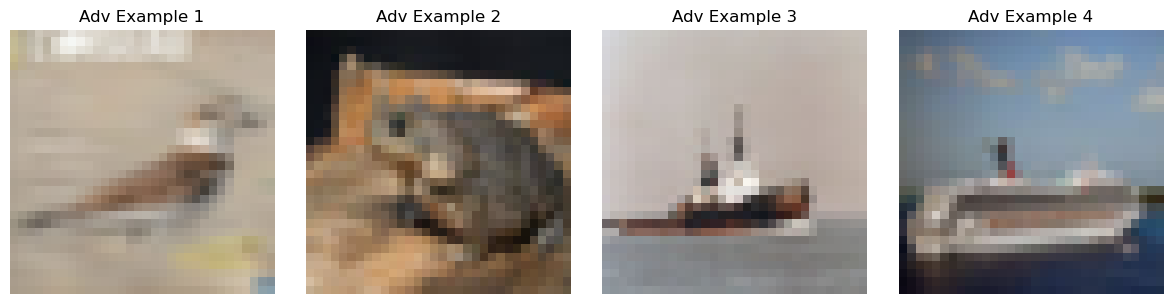

tensor([0, 0, 0, 0, 0], device='mps:0')
Attack success rate: 100.00%
5


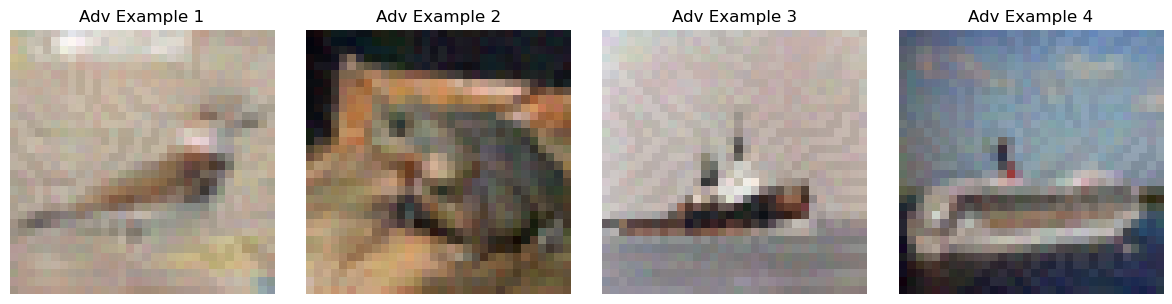

In [20]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[70:75], labels.to(device)[70:75]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [ ]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)